# HDBSCAN Clustering

Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN), is a clustering algorithm that can be applied to the AIA171 dataset obtained from the Solar Dynamic Observatory. The dataset consists of images, which are transformed into 1D power spectra to serve as the feature vectors. HDBSCAN enables the identification of clusters within the dataset by considering the density and connectivity of the data points. By applying HDBSCAN to the AIA171 dataset, we can uncover patterns, groupings, and anomalies in the solar observations, facilitating a deeper understanding of the underlying solar dynamics and potential insights into solar phenomena.

# Clone Repository from GitHub

In [1]:
!git clone https://github.com/hits-sdo/HITS-SDO-Independent-Research.git
%cd HITS-SDO-Independent-Research/
!git checkout main

c:\Github Repositories\HITS-SDO-Independent-Research\src\notebooks\HITS-SDO-Independent-Research


fatal: destination path 'HITS-SDO-Independent-Research' already exists and is not an empty directory.


Your branch is up to date with 'origin/main'.


Already on 'main'


# Download Data

In [2]:
!gdown 16WD0td1f5gx4yIIDkWWSTb-oZcezI1CU
!tar -zxf AIA171_Miniset_BW.tar.gz

Downloading...
From (uriginal): https://drive.google.com/uc?id=16WD0td1f5gx4yIIDkWWSTb-oZcezI1CU
From (redirected): https://drive.google.com/uc?id=16WD0td1f5gx4yIIDkWWSTb-oZcezI1CU&confirm=t&uuid=849e9cce-b6ac-44de-96a8-39f557bf575b
To: c:\Github Repositories\HITS-SDO-Independent-Research\src\notebooks\HITS-SDO-Independent-Research\AIA171_Miniset_BW.tar.gz

  0%|          | 0.00/147M [00:00<?, ?B/s]
  0%|          | 524k/147M [00:00<00:33, 4.37MB/s]
  1%|▏         | 2.10M/147M [00:00<00:16, 8.85MB/s]
  3%|▎         | 3.67M/147M [00:00<00:14, 10.0MB/s]
  4%|▎         | 5.24M/147M [00:00<00:13, 10.8MB/s]
  5%|▍         | 6.82M/147M [00:00<00:12, 11.0MB/s]
  6%|▌         | 8.39M/147M [00:00<00:12, 11.3MB/s]
  7%|▋         | 9.96M/147M [00:00<00:12, 11.3MB/s]
  8%|▊         | 11.5M/147M [00:01<00:11, 11.3MB/s]
  9%|▉         | 13.1M/147M [00:01<00:11, 11.4MB/s]
 10%|█         | 14.7M/147M [00:01<00:11, 11.4MB/s]
 11%|█         | 16.3M/147M [00:01<00:11, 11.5MB/s]
 12%|█▏        | 17.8M/147

## Import Libraries

In [3]:
!pip install -q -r requirements.txt

In [4]:
# Import Libraries
import numpy as np
import scipy.stats as stats
import glob
import PIL.Image as Image
from sklearn.manifold import TSNE
import hdbscan
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import matplotlib.offsetbox as offsetbox

## Data Pre-Processing

### Converting a 2D image into its 1D Power Spectrum

Converting a 2D grayscaled image into its 1D power spectrum can be done as such:
1. Apply the 2D Fast Fourier Transform (FFT) to the image. This is done using the FFT method in the numpy library.
2. Once the FFT is applied, obtain the magnitude spectrum by taking the absolute value of the complex-valued result obtained from the FFT.
3. To convert the 2D power spectrum into 1D, average the magnitudes along concentric circles centered at the image's origin (zero frequency). This is done by calculating the average magnitude for each radius, starting from the center and moving outwards.
4. The resulting radial profile represents the 1D power spectrum, with the x-axis representing the radius and the y-axis representing the average magnitude or power at each radius.

The cell below is the method that follows the steps above to calulate the 1D power specturm

In [5]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    # Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)

    return a_bins

# Calculates Wasserstein distance of two images
def wasserstein(x, y):
    return stats.wasserstein_distance(np.arange(len(x)), np.arange(len(y)), x, y)

### Reading the Dataset
This cell creates two vectors: One to store the original image represented as a numpy array, and another to store the 1D power spectrum of the image

In [6]:
# Collect all images in AIA171_Miniset_BW and represent them as 1D power specturm numpy arrays
images = []
x = []
data_stride = 5

image_paths = glob.glob('./AIA171_Miniset_BW/**/*.jpg', recursive = True)
if data_stride > 1:
    image_paths = image_paths[::data_stride]

for image_path in image_paths:
    image = Image.open(image_path).convert('L')
    image = np.array(image)
    image = image.astype(np.float32) / 255
    pow_spect = power_spectrum_1d(image)
    if pow_spect.any():
        images.append(image)
        x.append(pow_spect)

images = np.array(images)
x = np.array(x)

### Dimensionality Reduction using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space. It aims to capture the underlying structure and relationships within the data by preserving the pairwise similarities between data points.

The cell below employs t-SNE using the scikit-learn method

In [7]:
embedded_x = TSNE().fit_transform(x)

x_max = np.max(embedded_x, axis=0)
x_min = np.min(embedded_x, axis=0)
embedded_x = (embedded_x - x_min) / (x_max - x_min)

## Data Clustering

### HDBSCAN

-0.18114428196334356


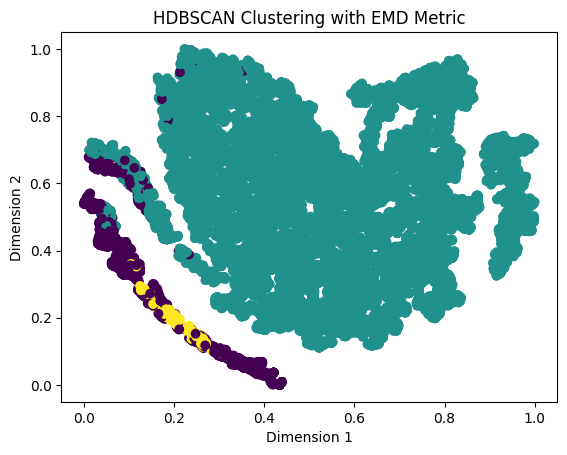

In [8]:
# Create an instance of HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True, metric=wasserstein)

# Fit the clusterer to the batch data
clusterer.fit(x)

# Get the cluster labels for this batch
labels = clusterer.labels_

score = silhouette_score(x, labels)
print(score)

plt.scatter(embedded_x[:,0], embedded_x[:,1], c = labels)
plt.title('HDBSCAN Clustering with EMD Metric')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()